In [53]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

In [54]:
!tar xf ../data/results.tar.gz

In [55]:
!mv results/ ../data/

In [56]:
DATA_ROOT='../data/results/granularity/'

In [57]:
modes = sorted(list(map(lambda path: os.path.basename(path), glob.glob(DATA_ROOT + '/*'))))
modes

['128MB', '16MB', '1GB', '256MB', '2GB', '32MB', '512MB', '64MB']

In [58]:
# load into dataframe for analysis

In [93]:
rows = []
for mode in modes:
    print('>> loading {}'.format(mode))
    row = {'mode' : mode}
    
    num = len(glob.glob(os.path.join(DATA_ROOT, mode, 'log-run-*.txt')))
    
    # there should be 11 logs in there
    for run in range(num):
        path = os.path.join(DATA_ROOT, mode, 'log-run-{}.txt'.format(run + 1))
        json_path = os.path.join(DATA_ROOT, mode, 'job/job_{:04d}.json'.format(run))
       
        # load each and add data
        row['run'] = run 
        row['path'] = path if os.path.isfile(path) else None
        row['json_path'] = json_path if os.path.isfile(json_path) else None
        
        # read time
        try:
            with open(path, 'r') as fp:
                lines = fp.readlines()
                line = list(filter(lambda line: line.startswith('{"startupTime":'), lines))[0]
                d = json.loads(line.strip())
                row['job_time'] = d['jobTime']
        except:
            row['job_time'] = None
        
        # analyze paths & times
        try:
            with open(json_path, 'r') as fp:
                data = json.load(fp)
                
                in_normal = data['input_paths_taken']['normal']
                in_general = data['input_paths_taken']['general']
                in_fallback = data['input_paths_taken']['fallback']
                in_unresolved = data['input_paths_taken']['unresolved']

                out_normal = data['output_paths_taken']['normal']
                out_unresolved = data['output_paths_taken']['unresolved']

                requests = data['requests']
                
                timings = dict(zip(['t_fast', 't_slow', 't_hyper', 't_compile', 't_fast_per_row'],
                                [0, 0, 0, 0, 0]))
                num_reqs_with_normal = 0
                for req in requests:
                    for k in ['t_fast', 't_slow', 't_hyper', 't_compile']:
                        timings[k] += req.get(k, None)
                    r_in_normal = req['input_paths_taken']['normal']
                    if 0 != r_in_normal:
                        timings['t_fast_per_row'] += req['t_fast'] / r_in_normal
                        num_reqs_with_normal += 1
                        
                row['in_normal'] = in_normal
                row['in_general'] = in_general
                row['in_fallback'] = in_fallback
                row['in_unresolved'] = in_unresolved
                row['out_normal'] = out_normal
                row['out_unresolved'] = out_unresolved
                
                row['cost'] = data['cost']
                
                timings['t_fast_per_row'] /= num_reqs_with_normal
                row.update(timings)

        except:
            pass
        
        
        rows.append(row)
        
df = pd.DataFrame(rows)

>> loading 128MB
>> loading 16MB
>> loading 1GB
>> loading 256MB
>> loading 2GB
>> loading 32MB
>> loading 512MB
>> loading 64MB


In [94]:
# exclude failed jobs (need to fix those later)
expected_normal_out = 294195
expected_input_rows = 11012665
expected_exceptions = 20785 # <-- without filter pushdown.

In [95]:
df['out_normal'].min(), df['out_normal'].max()

(294195, 294195)

In [96]:
df['in_total'] = df['in_normal'] + df['in_general'] + df['in_fallback'] + df['in_unresolved']
df['in_total'].min(), df['in_total'].max()

(11012665, 11012667)

In [97]:
m = {'16MB' : 16, '32MB': 32, '64MB' : 64, '128MB':128, '256MB' : 256, '512MB' : 512, '1GB':1024, '2GB':2048}
df['size'] = df['mode'].apply(lambda x: m[x])
df = df.sort_values(by='size').reset_index(drop=True)

In [98]:
df_ok = df[df['out_normal'] == expected_normal_out]

In [99]:
df_ok.head()

,mode,run,path,json_path,job_time,in_normal,in_general,in_fallback,in_unresolved,out_normal,out_unresolved,cost,t_fast,t_slow,t_hyper,t_compile,t_fast_per_row,in_total,size
0,16MB,2,../data/results/granularity/16MB/log-run-3.txt,../data/results/granularity/16MB/job/job_0002....,23.548118,5498186,3611779,1902702,0,294195,0,0.989385,3017.124050,1389.295186,839.418127,268.111701,0.001060,11012667,16
1,16MB,2,../data/results/granularity/16MB/log-run-3.txt,../data/results/granularity/16MB/job/job_0002....,23.548118,5498186,3611779,1902702,0,294195,0,0.989385,3017.124050,1389.295186,839.418127,268.111701,0.001060,11012667,16
2,16MB,2,../data/results/granularity/16MB/log-run-3.txt,../data/results/granularity/16MB/job/job_0002....,23.548118,5498186,3611779,1902702,0,294195,0,0.989385,3017.124050,1389.295186,839.418127,268.111701,0.001060,11012667,16
3,32MB,2,../data/results/granularity/32MB/log-run-3.txt,../data/results/granularity/32MB/job/job_0002....,11.961468,5505676,3603136,1903854,0,294195,0,0.493887,1366.497052,803.542336,461.655419,133.669923,0.000544,11012666,32
4,32MB,2,../data/results/granularity/32MB/log-run-3.txt,../data/results/granularity/32MB/job/job_0002....,11.961468,5505676,3603136,1903854,0,294195,0,0.493887,1366.497052,803.542336,461.655419,133.669923,0.000544,11012666,32


In [100]:
print('{}/{} runs not ok'.format(len(df) - len(df_ok), len(df)))

0/24 runs not ok


In [101]:
if 0 == len(df_ok):
    df_ok = df

Text(0, 0.5, 'end-to-end time in s')

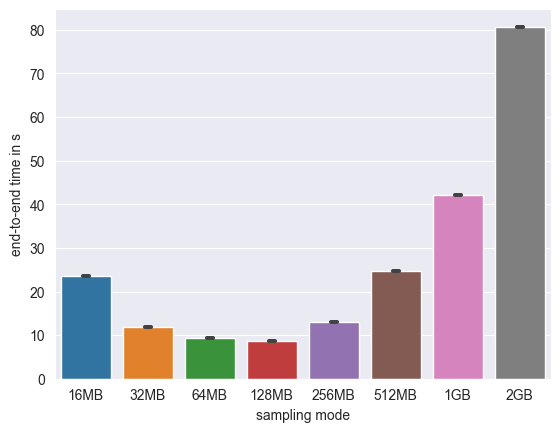

In [102]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='job_time', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('end-to-end time in s')

Text(0, 0.5, '#normal rows')

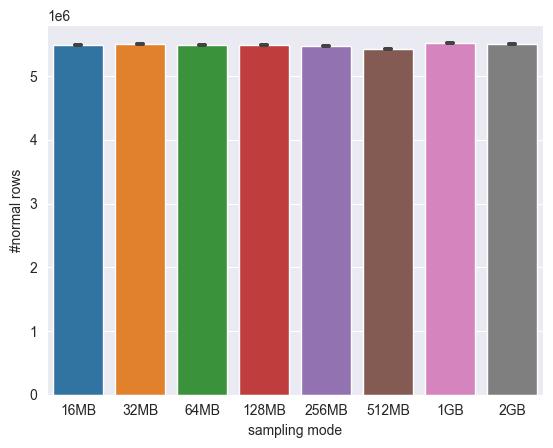

In [103]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='in_normal', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#normal rows')

Text(0, 0.5, '#general rows')

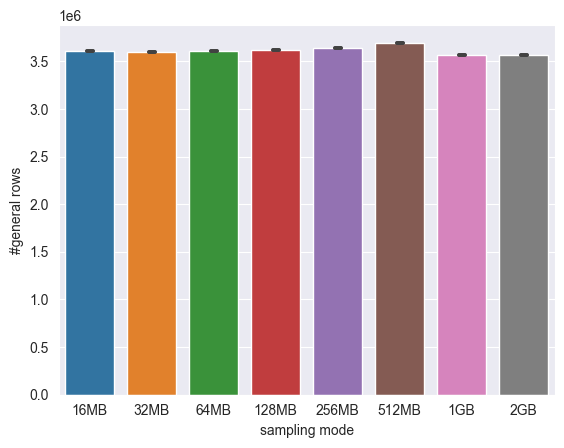

In [104]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='in_general', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#general rows')

Text(0, 0.5, '#fallback rows')

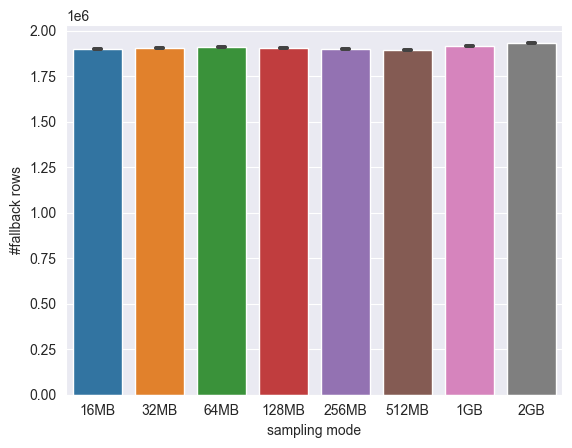

In [105]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='in_fallback', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#fallback rows')

Note that general-case for hyper is the same as in A/B to keep sampling cost on driver cheap.

Text(0, 0.5, 'time in fast path')

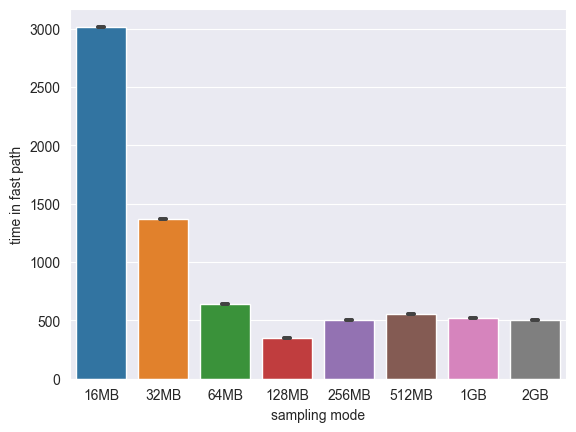

In [106]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_fast', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in fast path')
#plt.ylim(700, 850)

Text(0, 0.5, 'time in slow (general + interpreter) path')

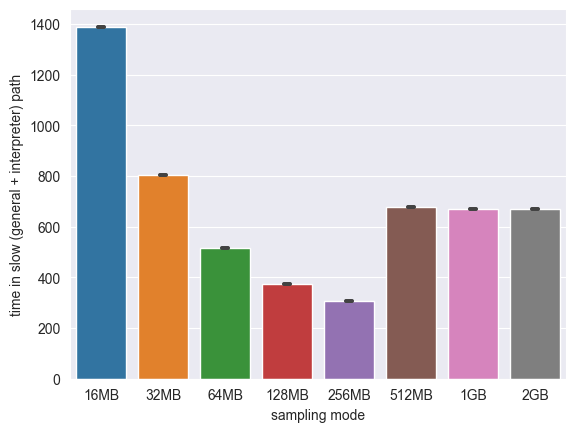

In [107]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_slow', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in slow (general + interpreter) path')

Text(0, 0.5, 'time spend compiling')

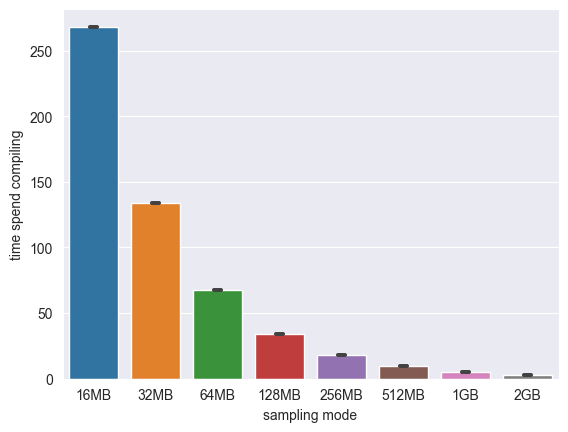

In [108]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_compile', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend compiling')

Text(0, 0.5, 'time spend hyperspecializing')

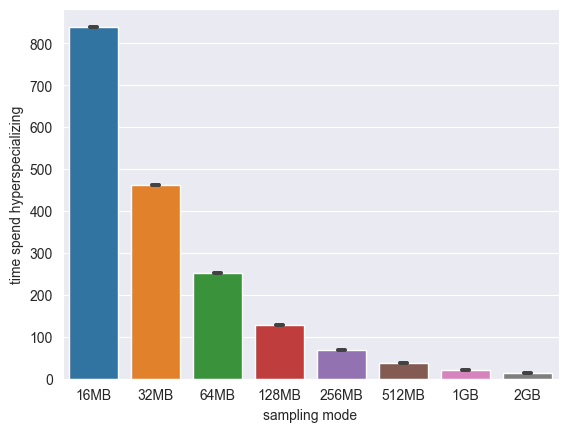

In [109]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_hyper', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend hyperspecializing')

Text(0, 0.5, 'cost per query in $ (USD)')

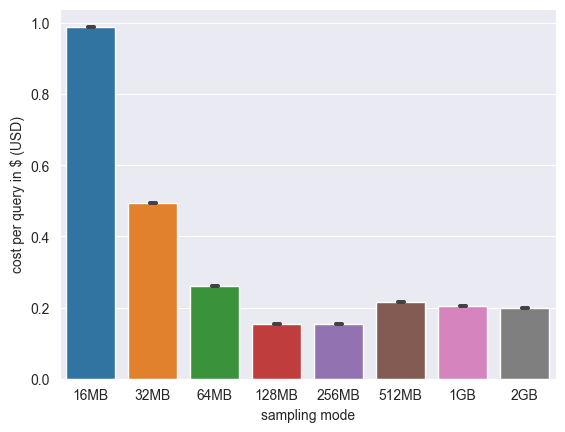

In [110]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='cost', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('cost per query in $ (USD)')

In [111]:
# plot trade-off cost vs. time

Text(0, 0.5, 'query cost in $')

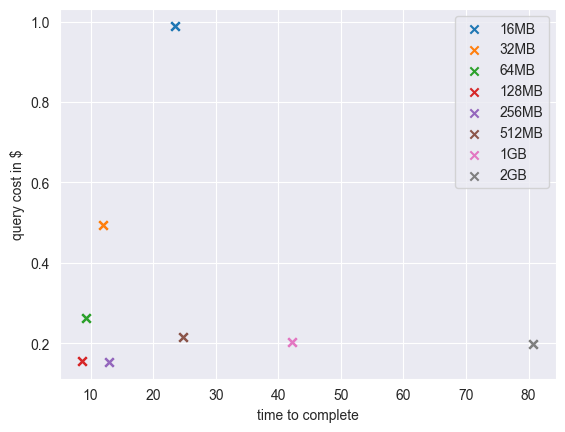

In [112]:
import itertools
marker = itertools.cycle(('x', 'v', '^', ',', '+', '>', 'o', '<')) 
marker = itertools.cycle(('x')) 
for i, mode in enumerate(df_ok['mode'].unique()):
    plt.scatter(df_ok[df_ok['mode'] == mode]['job_time'], 
                df_ok[df_ok['mode'] == mode]['cost'], label=mode, 
               marker=next(marker))
plt.legend()
#plt.ylim(0, 0.6)
#plt.xlim(0, 60)
plt.xlabel('time to complete')
plt.ylabel('query cost in $')

### Trying to make sense of new results:

What changed?


- general case is now compiled in when query starts (global general case). 
- execution in hyper mode is blocked till hyperspecialization is complete (compared to global mode where compilation/execution starts right away)
- for serialization Cereal is now used instead of JSON
- some bugfixes regarding chunking
- interpreter path now faster (don't know percentage) by memoizing `cloudpickle.loads`
- better buffer sizes used, increased parallelism to 574

Why is hyper so bad in this experiment?

(Following is total aggregate time spent)

In [113]:
df = df_ok

In [114]:
df['t_exec'] = df['t_fast'] + df['t_slow']

df.groupby('mode')['t_exec'].mean()

mode
128MB     720.833492
16MB     4406.419236
1GB      1190.499123
256MB     811.005565
2GB      1170.382938
32MB     2170.039388
512MB    1232.538338
64MB     1151.893688
Name: t_exec, dtype: float64

Hyper provides benefit for overall execution time - but it doesn't offset the other costs.

In [115]:
df['t_cost'] = df['t_compile'] + df['t_hyper']
df.groupby('mode')['t_cost'].mean()

mode
128MB     162.986402
16MB     1107.529828
1GB        26.026342
256MB      86.331449
2GB        16.581823
32MB      595.325342
512MB      46.341690
64MB      319.304510
Name: t_cost, dtype: float64

In [116]:
df = df.groupby('mode').mean()

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_35667/1383793785.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('mode').mean()


In [117]:
df = df.sort_values(by='size').reset_index(drop=True)

Text(0, 0.5, 'total time in s')

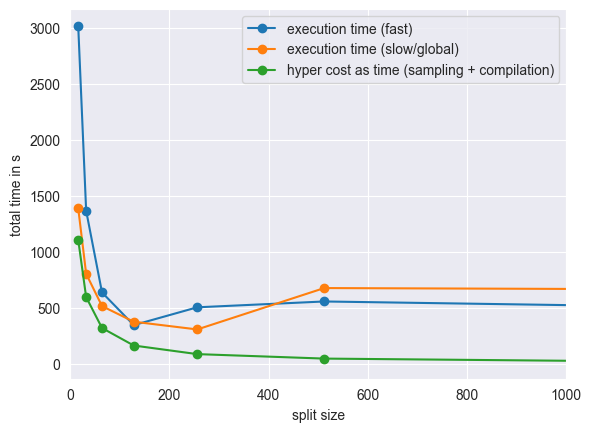

In [129]:
plt.plot(df['size'], df['t_fast'], marker='o', label='execution time (fast)')
plt.plot(df['size'], df['t_slow'], marker='o', label='execution time (slow/global)')

plt.plot(df['size'], df['t_cost'], marker='o', label='hyper cost as time (sampling + compilation)')
plt.legend(loc='best')
plt.xlabel('split size')
plt.xlim(0, 1000)
plt.ylabel('total time in s')

In [127]:
df['t_per_row_fast'] = df['t_fast'] / df['in_normal'] * 1000
df['t_per_row_slow'] = df['t_slow'] / (df['in_general'] + df['in_fallback']) * 1000

Text(0, 0.5, 'time in ms')

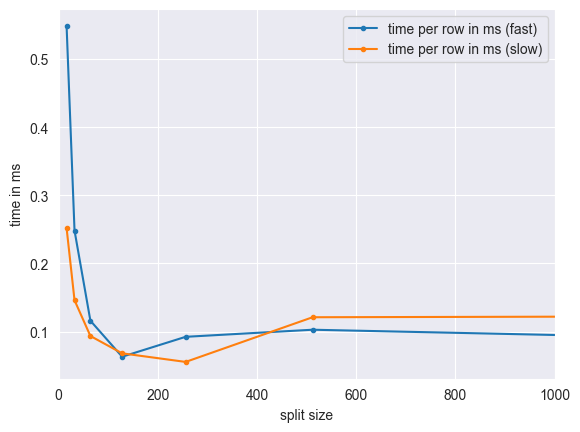

In [128]:
plt.plot(df['size'], df['t_per_row_fast'], marker='.', label='time per row in ms (fast)')
plt.plot(df['size'], df['t_per_row_slow'], marker='.', label='time per row in ms (slow)')
plt.legend(loc='best')
plt.xlabel('split size')
plt.xlim(0, 1000)
plt.ylabel('time in ms')

In [ ]:
df['t_fast']

Looking at hyperspecialization itself:
- sampling + hyperspecialization is the main cost (whereas compile time cost only increases by a bit!)
- could sample ONCE per file/hyperspecialize and then scale out

In [31]:
df[df['mode'] == 'hyper'][['t_compile', 't_hyper']].mean()

t_compile   NaN
t_hyper     NaN
dtype: float64

Also note that the "opportune" compilation of the general case comes at the cost of increasing query costs!

- i.e., by disabling it when a normal-case runs through without exceptions/deoptimizations this cost can be avoided!

By adding more logic (i.e. decoding forkEvent specific fields from payload), hyper should also benefit more b.c. it triggers more deoptimization.

TODOs:
    
    - filter promo
    - projections pushdown
    - compare for single file our fallback vs. another framework

In [39]:
!rm -rf ../data/results/

Other improvement ideas:
- currently, when hyperspecializing another (1-2) requests to S3 are issued. This is redundant and could be avoided totally, i.e. by just sampling for the first rows and issuing the full s3 request to read the input file in the beginning.
    - effect: around 120ms per Lambda saved
    
- when parsing the sample, a super slow routine is used. Instead of parsing as Tuplex Rows and registering all sorts of types immediately with the type system it could be faster to parse to type strings, then detect majority (*hashing string is fast*), and then register types. 
    - effect: just parsing the rows takes about 600ms or so

In [40]:
408 / 547

0.7458866544789763

Plot here detailed hyperspecialization cost per uri out.

In [42]:
rows = []
mode = 'hyper'
print('>> loading {}'.format(mode))
row = {'mode' : mode}

num = len(glob.glob(os.path.join(DATA_ROOT, mode, 'log-run-*.txt')))

# there should be 11 logs in there
for run in range(num):
    path = os.path.join(DATA_ROOT, mode, 'log-run-{}.txt'.format(run + 1))
    json_path = os.path.join(DATA_ROOT, mode, 'job/job_{:04d}.json'.format(run))

    # load each and add data
    row['run'] = run 
    row['path'] = path if os.path.isfile(path) else None
    row['json_path'] = json_path if os.path.isfile(json_path) else None

    # read time
    try:
        with open(path, 'r') as fp:
            lines = fp.readlines()
            line = list(filter(lambda line: line.startswith('{"startupTime":'), lines))[0]
            d = json.loads(line.strip())
            row['job_time'] = d['jobTime']
    except:
        row['job_time'] = None

    # analyze paths & times
    try:
        with open(json_path, 'r') as fp:
            data = json.load(fp)

            in_normal = data['input_paths_taken']['normal']
            in_general = data['input_paths_taken']['general']
            in_fallback = data['input_paths_taken']['fallback']
            in_unresolved = data['input_paths_taken']['unresolved']

            out_normal = data['output_paths_taken']['normal']
            out_unresolved = data['output_paths_taken']['unresolved']

            requests = data['requests']

            timings = dict(zip(['t_fast', 't_slow', 't_hyper', 't_compile', 't_fast_per_row'],
                            [0, 0, 0, 0, 0]))
            num_reqs_with_normal = 0
            for req in requests:
                for k in ['t_fast', 't_slow', 't_hyper', 't_compile']:
                    timings[k] += req.get(k, None)
                r_in_normal = req['input_paths_taken']['normal']
                if 0 != r_in_normal:
                    timings['t_fast_per_row'] += req['t_fast'] / r_in_normal
                    num_reqs_with_normal += 1

            row['in_normal'] = in_normal
            row['in_general'] = in_general
            row['in_fallback'] = in_fallback
            row['in_unresolved'] = in_unresolved
            row['out_normal'] = out_normal
            row['out_unresolved'] = out_unresolved

            row['cost'] = data['cost']

            timings['t_fast_per_row'] /= num_reqs_with_normal
            row.update(timings)

    except:
        pass


    rows.append(row)

>> loading hyper


In [160]:
mode = 'hyper'
print('>> loading {}'.format(mode))
num = len(glob.glob(os.path.join(DATA_ROOT, mode, 'log-run-*.txt')))
print(num)
# there should be 11 logs in there
for run in range(num):
    path = os.path.join(DATA_ROOT, mode, 'log-run-{}.txt'.format(run + 1))
    json_path = os.path.join(DATA_ROOT, mode, 'job/job_{:04d}.json'.format(run))

    # analyze paths & times
    try:
        with open(json_path, 'r') as fp:
            data = json.load(fp)
            requests = data['requests']

    except:
        print('fail')
        pass

>> loading hyper
5


In [161]:
request_dict = {}
for req in requests:
    request_dict[req['requestId']] = req
    

In [162]:
tasks = data['tasks']

In [163]:
rows = []
for task in tasks:
    req_id = task['container']['requestId']
    req = request_dict[req_id]
    req['input_uri'] = task['input_uris'][0]
    req['mode'] = mode
    rows.append(req)

In [164]:
import os
import functools

In [165]:
# def sort_by_year_and_range(x, y):
#     a = x['input_uri']
#     b = y['input_uri']

#     a = os.path.basename(a)
#     b = os.path.basename(b)
    
#     a_y = int(a.split('-')[0])
#     b_y = int(b.split('-')[0])
    
#     a_s = a[a.rfind(':')+1:]
#     b_s = b[b.rfind(':')+1:]
    
#     a_s = int(a_s.split('-')[0])
#     b_s = int(b_s.split('-')[0])
    
#     return a_y <= b_y and a_s <= b_s
    
# sorted(rows, key=functools.cmp_to_key(sort_by_year_and_range))

In [166]:
df = pd.DataFrame(rows)

In [167]:
df['year'] = df['input_uri'].apply(lambda x: int(os.path.basename(x).split('-')[0]))

In [168]:
def extract_start_range(uri):
    
    a = os.path.basename(uri)
    a_s = a[a.rfind(':')+1:]
    return int(a_s.split('-')[0])
        
    
df['start_range'] = df['input_uri'].apply(extract_start_range)

In [169]:
df = df.sort_values(by=['year', 'start_range']).reset_index(drop=True)

In [170]:
df

,requestId,containerId,durationInMs,billedDurationInMs,memorySizeInMb,maxMemoryUsedInMb,returnCode,errorMessage,input_paths_taken,output_paths_taken,t_hyper,t_compile,t_fast,t_slow,tsRequestStart,tsRequestEnd,input_uri,mode,year,start_range
0,c359967a-93cf-4f33-9f37-3aec9bfcb9d7,87e6ba92-b792-42c5-bc38-ca918fb28f8c,2873.18,2874,10000,1946,0,,"{'normal': 20226, 'general': 19208, 'fallback'...","{'normal': 1237, 'unresolved': 0}",0.950798,0.135947,1.252570,0.375938,1668550788643322498,1668550791623989148,s3://tuplex-public/data/github_daily/2011-10-1...,hyper,2011,0
1,a315da2f-0c67-4f65-addd-3d0f2fa22068,92bbd663-ce8f-4f7b-a7a1-34ad856ea088,1672.31,1673,10000,897,0,,"{'normal': 3847, 'general': 2975, 'fallback': ...","{'normal': 181, 'unresolved': 0}",0.821739,0.143408,0.264158,0.346120,1668550788648694569,1668550790473490726,s3://tuplex-public/data/github_daily/2011-10-1...,hyper,2011,67108864
2,b5c2ccbf-932b-42a3-8a27-1c4e35625bca,cfe458ac-3010-45da-8251-5e57a5320894,8155.59,8156,10000,1988,0,,"{'normal': 3228, 'general': 179, 'fallback': 4...","{'normal': 1985, 'unresolved': 0}",2.320080,0.126756,2.966770,2.470840,1668550788653771825,1668550796963090207,s3://tuplex-public/data/github_daily/2012-10-1...,hyper,2012,0
3,d0e9c979-0539-45d2-a28f-007fe390c811,e998081b-4b51-4083-b15e-3b5e99ab9b7e,4866.49,4867,10000,1551,0,,"{'normal': 20847, 'general': 340, 'fallback': ...","{'normal': 1746, 'unresolved': 0}",2.115150,0.101131,1.063720,1.379750,1668550788658979798,1668550793681469745,s3://tuplex-public/data/github_daily/2012-10-1...,hyper,2012,67108864
4,0d0912df-75f7-41bc-b605-723060d68d1f,c729421a-d68a-4fae-b440-0355fbe21d3b,6295.02,6296,10000,1574,0,,"{'normal': 1311, 'general': 181, 'fallback': 5...","{'normal': 1708, 'unresolved': 0}",2.377990,0.131885,1.035750,2.313810,1668550788664059957,1668550795112614562,s3://tuplex-public/data/github_daily/2012-10-1...,hyper,2012,134217728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,d28f6b53-7b7c-4f18-915e-c563511a158b,9ed7cfdd-8e5e-4923-957e-6ecd1183904b,2403.30,2404,10000,1929,0,,"{'normal': 11064, 'general': 6070, 'fallback':...","{'normal': 302, 'unresolved': 0}",0.541626,0.092557,1.467760,0.242950,1668550792256389828,1668550794745248745,s3://tuplex-public/data/github_daily/2021-10-1...,hyper,2021,3288334336
570,da2f9862-83cf-4ac7-b00e-76885c4e03e7,c43769d1-bbd8-41c0-a517-d5b9b60732e0,2103.38,2104,10000,2578,0,,"{'normal': 13064, 'general': 6234, 'fallback':...","{'normal': 399, 'unresolved': 0}",0.654391,0.105695,0.937304,0.301065,1668550792261504893,1668550794453786449,s3://tuplex-public/data/github_daily/2021-10-1...,hyper,2021,3355443200
571,c825167c-eb95-4e52-beec-8ef1670cd3c8,5fa1e49a-ac4e-433d-b124-a4a481d8a157,2103.38,2104,10000,1520,0,,"{'normal': 12330, 'general': 6042, 'fallback':...","{'normal': 300, 'unresolved': 0}",0.658399,0.108081,0.954627,0.261125,1668550792266524822,1668550794456468754,s3://tuplex-public/data/github_daily/2021-10-1...,hyper,2021,3422552064
572,3930f922-1b5f-4b25-8657-d3004fb7b4ce,d0e1d889-9d7c-49dc-99f6-960b71f77966,2132.53,2133,10000,1093,0,,"{'normal': 14025, 'general': 6240, 'fallback':...","{'normal': 398, 'unresolved': 0}",0.588317,0.105651,1.072350,0.302439,1668550792271788608,1668550794490254620,s3://tuplex-public/data/github_daily/2021-10-1...,hyper,2021,3489660928


In [171]:
data['hyper_mode']

True

In [172]:
import numpy as np

Text(0.5, 1.0, 'hyperspecialization time')

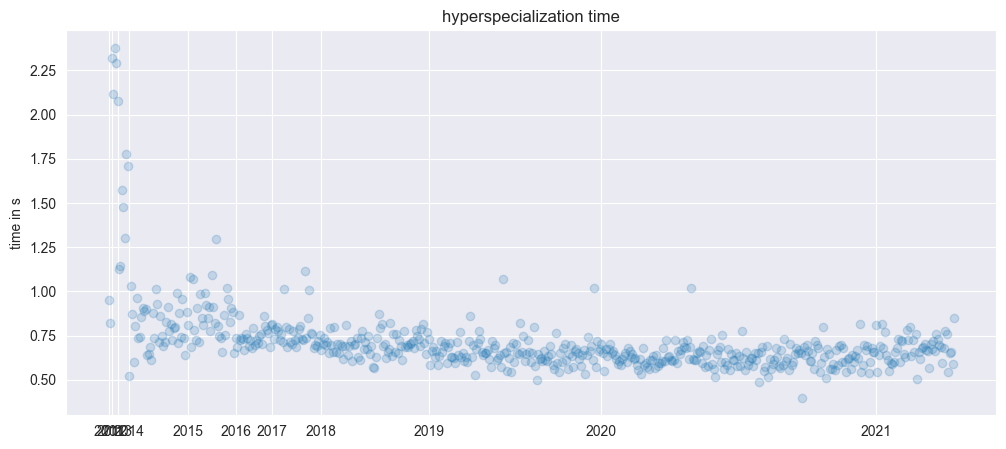

In [173]:
plt.figure(figsize=(12, 5))
plt.scatter(np.arange(len(df)), df['t_hyper'], alpha=.2)
plt.ylabel('time in s')
plt.xticks(year_indices, np.arange(2011, 2022))
plt.title('hyperspecialization time')

The outliers are probably, because more rows are parsed in the early years due to the smaller row size. Could simply limit number of rows to use for sampling.

(0.0, 5.0)

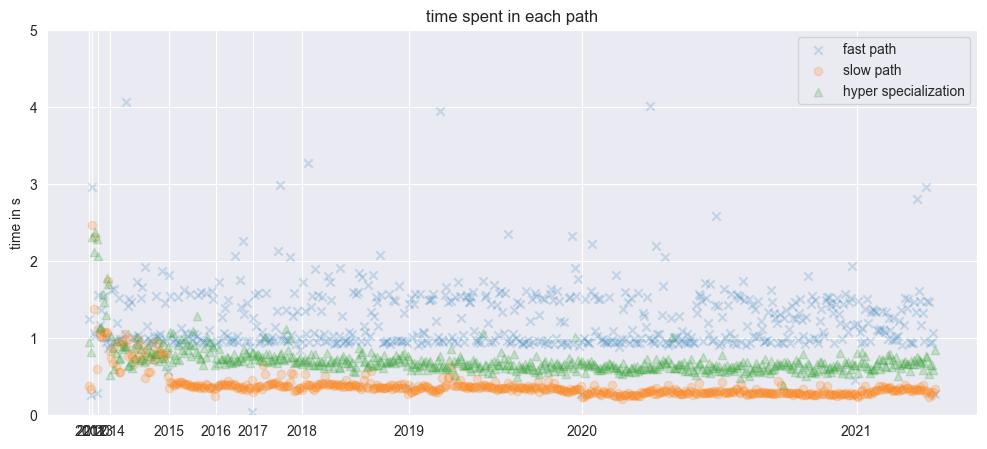

In [174]:
plt.figure(figsize=(12, 5))
plt.scatter(np.arange(len(df)), df['t_fast'], marker='x', alpha=.2, label='fast path')
plt.scatter(np.arange(len(df)), df['t_slow'], marker='o', alpha=.2, label='slow path')
if df['t_hyper'].sum() > 0:
    plt.scatter(np.arange(len(df)), df['t_hyper'], marker='^', alpha=.2, label='hyper specialization')
plt.ylabel('time in s')
plt.xticks(year_indices, np.arange(2011, 2022))
plt.legend()
plt.title('time spent in each path')
plt.ylim(0, 5)